In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Import Data

In [2]:
data = pd.read_csv('../raw_data/fer2013.csv')

In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Label emotions

In [4]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


## Data checks

In [5]:
## shape of the dataset

data.shape

(35887, 3)

In [6]:
## checking for null values

data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [7]:
## check image sizes

data['image_sizes'] = data['pixels'].apply(lambda x: len(x.split()))

In [8]:
data.head()

,emotion,pixels,Usage,image_sizes
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,2304
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,2304
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,2304
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,2304
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,2304


In [9]:
data['image_sizes'].unique()

array([2304])

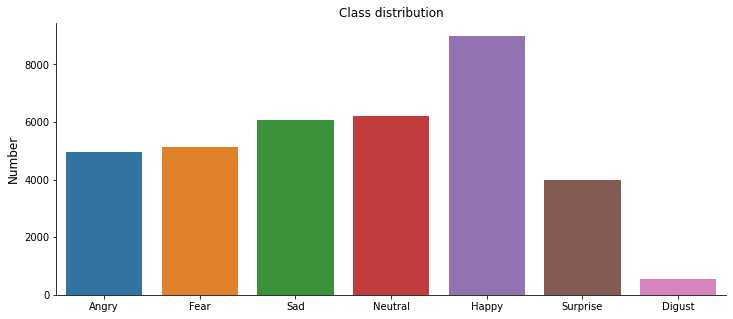

In [10]:
plt.figure(figsize=(12,5))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('', fontsize=12)
sns.despine()
plt.show()

In [11]:
from sklearn.metrics import classification_report

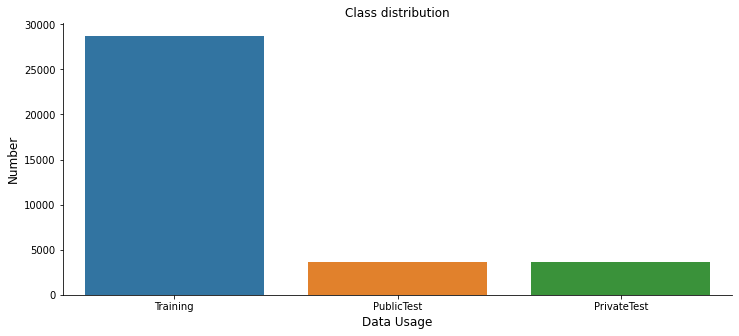

In [12]:
usage_counts = data['Usage'].value_counts(sort=False).reset_index()
usage_counts.columns = ['usage', 'number']

plt.figure(figsize=(12,5))
sns.barplot(x=usage_counts.usage, y=usage_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Data Usage', fontsize=12)
sns.despine()
plt.show()

## Visualise dataset

In [13]:
def row2image(row):
    emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear',
                   3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    return img.astype(np.uint16), emotion

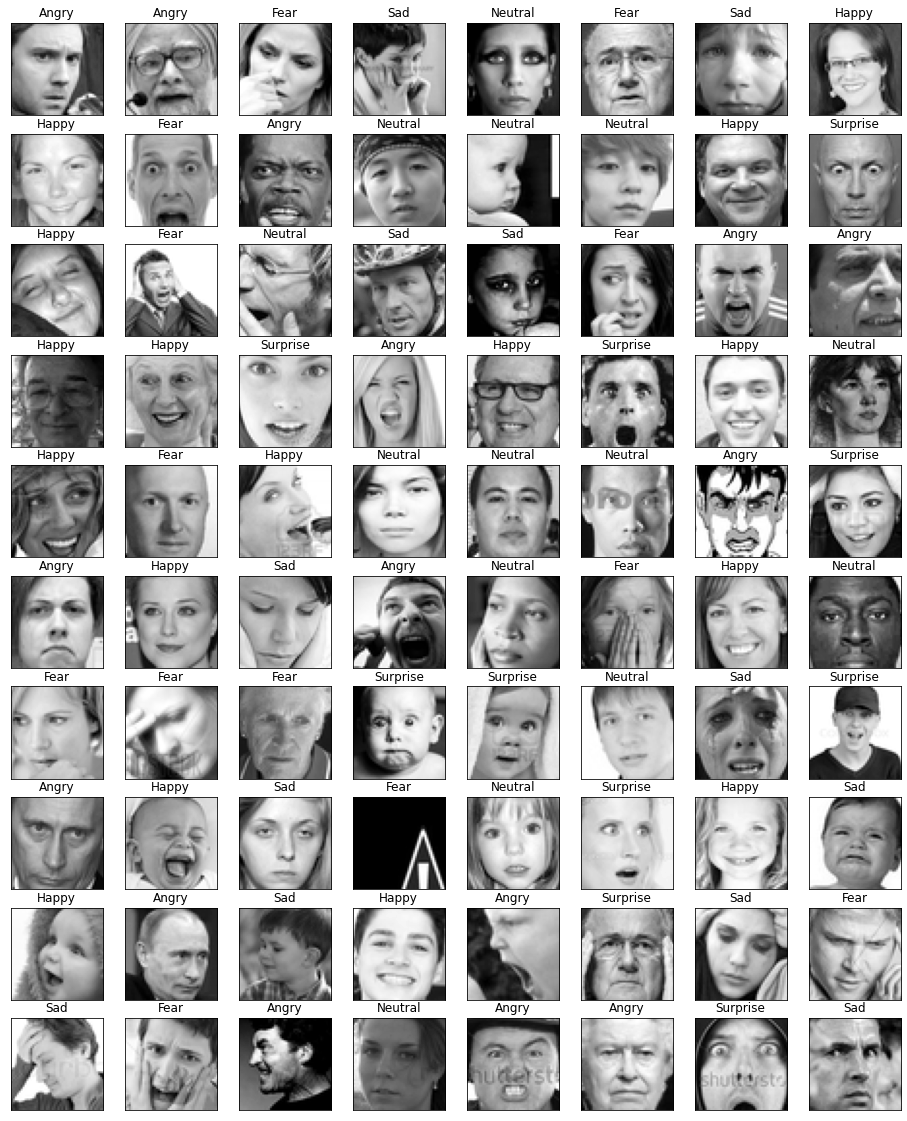

In [14]:
fig = plt.figure(figsize=(16,20))

train_data = data.loc[data['Usage'] == "Training"]
for i in range(80):
    img = row2image(train_data.iloc[i])
    plt.subplot(10, 8, i + 1)
    plt.title(img[1], size=12)
    plt.imshow(img[0], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(());

## Clean dataset

In [ ]:
# Create std deviation of pixels (colour in image) column
values = [np.array(pixels.split(),np.int16).std() for pixels in data.pixels]
values = pd.Series(values).to_frame('Std')

data['std_dev'] = values

In [ ]:
# filter out images with 0 variance
data = data.loc[data['std_dev'] > 0]

In [ ]:
# image check
img, emotion = row2image(data.iloc[56])
plt.title(emotion, size=12)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off');

In [ ]:
# new column converting pixels string to reshaped array
# data['pixels_array'] = data['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((48,48)))

# Model architecture (Jaildo notebook)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (5, 5), 
                 padding='same',
                 strides = (1,1),
                 input_shape=(48, 48, 1), 
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(7, activation='softmax'))

# Data augmentation

## Custom functions

In [ ]:
def row2image(X):
    emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear',
                   3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    return img.astype(np.uint16), emotion

In [ ]:
from numpy import expand_dims
import copy

# expand each array to 4D (1, X, X, 1) for flow
def expandto4D(x):
    # if array of arrays
    Xpanded = copy.deepcopy(x)
    if x.ndim == 1:
        for i in range(0,len(x)):
            Xpanded[i] = np.expand_dims(Xpanded[i], 0)
            Xpanded[i] = np.expand_dims(Xpanded[i], 3)
    # if single array
    elif x.ndim == 2:
        Xpanded = np.expand_dims(Xpanded, 0)
        Xpanded = np.expand_dims(Xpanded, 3)
    return Xpanded

# squeeze back to 2D (X, X) for dataframe
def squeezeto2D(x):
    Xpanded = copy.deepcopy(x)
    if Xpanded.ndim == 4:
        # remove first dimension of 4D array
        squeezed = np.squeeze(Xpanded, axis=0)
        # remove last dimension of 3D array
        squeezed = np.squeeze(squeezed, axis=2)
    return squeezed

In [ ]:
# convert string to array
def string2array(x):
    pixels = copy.deepcopy(x)
    if isinstance(pixels,np.ndarray):
        for i in range(0,len(pixels)):
            pixels[i] = np.fromstring(pixels[i], dtype=int, sep=' ').reshape((48,48))
    elif isinstance(pixels,str):
        pixels = np.fromstring(pixels, dtype=int, sep=' ').reshape((48,48))
    return pixels

# convert array to string
def array2string(x):
    converted = copy.deepcopy(x)
    converted = (converted).flatten().tolist()
    converted = " ".join(str(round(x)) for x in converted)
    converted = converted.replace("\n","")
    return converted

In [ ]:
# 2Darray-label combination to labelled image
def labelledarray2image4D(X,y):
    emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear',
                   3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    expandto4D(X)
    pixels, emotion = X, y
    img = X.reshape(48,48)
    return img.astype(np.uint16), emotion_map[emotion]

# 2D to 4D array
def array2image4D(img):
    img = img.reshape(0,48,48,0)
    return img.astype(np.uint16)

## Load original images

In [ ]:
## Create variables for training, validation and test data
train_set = data.loc[data['Usage'] == 'Training']
val_set = data.loc[data['Usage'] == 'PublicTest']
test_set = data.loc[data['Usage'] == 'PrivateTest']

In [ ]:
# load image dataset
X, y = train_set['pixels'].to_numpy(), train_set['emotion'].to_numpy()

In [ ]:
# filter dataset for augmentation further if applicable
X_aug = X[5:10]
y_aug = y[5:10]

# if full training set is to be used
# X_aug = X
# y_aug = y

In [ ]:
# expand each image array to 4D for flow
X_aug4D = expandto4D(string2array(X_aug))

In [ ]:
fig = plt.figure(figsize=(16,20))

for i in range(len(X_aug4D)):
    img = labelledarray2image4D(X_aug4D[i], y_aug[i])
    plt.subplot(10, 8, i + 1)
    plt.title(img[1], size=12)
    plt.imshow(img[0], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(());

## Define image data generation specs

In [ ]:
# create data generator
datagen = ImageDataGenerator(
    rotation_range=45, width_shift_range=5,
    height_shift_range=5, shear_range=0.25, zoom_range=0.5,
    channel_shift_range=10, horizontal_flip=True
)

In [ ]:
# determine how many new images we want to create in total
nr_photos = 16

In [ ]:
# calculate how many images should be generated for each existing one
multiplier = nr_photos/len(X_aug4D)
multiplier

## Run ImageDataGenerator

In [ ]:
# create data augmented images
# save them to folder
# append to dataframe
AugmentedDataset = []
for sample in range(0,len(X_aug4D)):
    i = 0
    for batch in datagen.flow(X_aug4D[sample],y=y_aug[sample].reshape(1,1),save_to_dir='AugmentedImages', save_prefix='DataAug', save_format='jpg'):
        AugmentedDataset.append(batch)
        new_row = {'emotion':y_aug[sample], 'pixels':array2string(batch[0]), 'Usage':"DataAug"}
        data = data.append(new_row, ignore_index=True)
        i += 1
        if i > multiplier:
            break 

In [ ]:
# visualize generated images
AugmentedDataset

fig = plt.figure(figsize=(16,20))

for i in range(len(AugmentedDataset)):
    img = labelledarray2image4D(AugmentedDataset[i][0], AugmentedDataset[i][1][0][0])
    plt.subplot(10, 8, i + 1)
    plt.title(img[1], size=12)
    plt.imshow(img[0], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(());

In [ ]:
# dataframe check
data.iloc[[0, -1]]

In [ ]:
data.to_csv('AugmentedImages/AugmentedData.csv', index=False)

## Image to compatible array

In [ ]:
from skimage.transform import resize

# load img in greyscale
img = load_img('SamplePhoto/SamplePhoto.png', color_mode='grayscale')
# convert loaded image to 4D array
img_array = img_to_array(img)  # creating a Numpy array with shape (X, X, 3)
img_resized = resize(img_array, (48, 48)) #resize to match dataset
img_array = img_resized.reshape((1,) + img_resized.shape)  # converting to a Numpy array with shape (X, X, 3, 1)

In [ ]:
img_array.shape

In [ ]:
img

In [ ]:
resized_array = squeezeto2D(img_array)

In [ ]:
# show image
plt.figure(figsize=(3,3))
plt.imshow(resized_array, cmap=plt.cm.gray, aspect='equal')
plt.axis('off');

# TBD - next steps

In [ ]:
# fit model on the augmented dataset
model.fit_generator(it, steps_per_epoch=len(X))

In [ ]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('bird.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-200,200])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()